In [ ]:
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.utils.class_weight import compute_class_weight
import torch
from torch.optim import AdamW
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string
import torch.nn as nn

In [ ]:
# Load the dataset
data = pd.read_csv('/content/pr.csv', encoding='latin_1')
data.dropna(inplace=True)
data = data.drop_duplicates()

In [ ]:
data.isnull().sum()

Articles          0
Predicted_type    0
dtype: int64

In [ ]:
data.isnull().any()

Articles          False
Predicted_type    False
dtype: bool

In [ ]:
data.dropna(inplace=True)

In [ ]:
data.isnull().any()

Articles          False
Predicted_type    False
dtype: bool

In [ ]:
data.duplicated().sum()

0

In [ ]:
data.shape

(10787, 2)

In [ ]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Data Preprocessing
def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    cleaned_text = ' '.join(tokens)
    return cleaned_text

In [ ]:
# Assuming 'data' is your DataFrame
# 'X' is the feature (Propaganda text), and 'y' is the target variable (Type)
X = data['Articles']
y = data['Predicted_type']

In [ ]:
nan_values_before_mapping = data['Predicted_type'].isnull().sum()
print(f"Number of NaN values before mapping: {nan_values_before_mapping}")

Number of NaN values before mapping: 0


In [ ]:
# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
data.head()

,Articles,Predicted_type
0,facebook ask user europ news sourc trust help ...,non-propaganda
1,tajikistan pardon 100 syria iraq returne afp d...,non-propaganda
2,share copi link video lauren yalangogr christo...,non-propaganda
3,pari franc nation rail oper convict discrimin ...,non-propaganda
4,beirut lebanon 800 thousand futur movement sup...,non-propaganda


In [ ]:
# Mapping the 'Type' labels to 0 and 1
data['Predicted_type'] = data['Predicted_type'].map({'non-propaganda': 0, 'propaganda': 1})

In [ ]:
data.head(100)

,Articles,Predicted_type
0,facebook ask user europ news sourc trust help ...,0
1,tajikistan pardon 100 syria iraq returne afp d...,0
2,share copi link video lauren yalangogr christo...,0
3,pari franc nation rail oper convict discrimin ...,0
4,beirut lebanon 800 thousand futur movement sup...,0
...,...,...
95,true spirit heroism love church sicilian pries...,1
96,erik pendzichrexshutterstock pari hilton atten...,0
97,presid donald trump reach inform agreement boe...,0
98,one presid trump former campaign aid michael c...,1


In [ ]:
# Feature Extraction - TF-IDF
tfidf = TfidfVectorizer(stop_words='english', preprocessor=clean_text)
tfidf_matrix_train = tfidf.fit_transform(train_data)
tfidf_matrix_test = tfidf.transform(test_data)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'thu', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev'] not in stop_words.
  warnings.warn(


In [ ]:
# Feature Extraction - Word Embeddings (example using Truncated SVD)
#embeddings_model = make_pipeline(StandardScaler(with_mean=False), TruncatedSVD(n_components=100))
#embeddings_matrix_train = embeddings_model.fit_transform(tfidf_matrix_train)
#embeddings_matrix_test = embeddings_model.transform(tfidf_matrix_test)

NameError: name 'make_pipeline' is not defined

In [ ]:
!pip install gensim==4.2.0

In [ ]:
import numpy as np
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

train_data_tokenized = [simple_preprocess(text) for text in train_data]
test_data_tokenized = [simple_preprocess(text) for text in test_data]

embedding_model = Word2Vec(train_data_tokenized, vector_size=100, window=5, min_count=1, workers=4)

def word_embedding_vectorizer(data, model):
    vectors = []
    for sentence in data:
        sentence_vec = []
        for word in sentence:
            if word in model.wv.key_to_index:
                sentence_vec.append(model.wv[word])
        vectors.append(np.mean(sentence_vec, axis=0))
    return np.array(vectors)

train_vectors = word_embedding_vectorizer(train_data_tokenized, embedding_model)
test_vectors = word_embedding_vectorizer(test_data_tokenized, embedding_model)

In [ ]:
train_features = np.concatenate((tfidf_matrix_train.toarray(), train_vectors), axis=1)
test_features = np.concatenate((tfidf_matrix_test.toarray(), test_vectors), axis=1)

In [ ]:
# Function to calculate class weights
def calculate_class_weights(labels):
    class_weights = compute_class_weight('balanced', np.unique(labels), labels)
    return torch.tensor(class_weights, dtype=torch.float32)

In [ ]:
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

In [ ]:
# Applying SMOTE for Naive Bayes
smote_nb = SMOTE(random_state=42)
#X_resampled_nb, y_resampled_nb = smote_nb.fit_resample(tfidf_matrix_train, train_labels)
X_resampled_nb, y_resampled_nb = smote_nb.fit_resample(train_features, train_labels)

# Naive Bayes
naive_bayes_model = MultinomialNB()
# Clip negative values to zero
X_resampled_nb = np.clip(X_resampled_nb, 0, None)

# Fit the Naive Bayes model again
naive_bayes_model.fit(X_resampled_nb, y_resampled_nb)


# SVM
#smote_svm = SMOTE(random_state=42)
#X_resampled_svm, y_resampled_svm = smote_svm.fit_resample(tfidf_matrix_train, train_labels)

#svm_model = make_pipeline(StandardScaler(with_mean=False), SVC(kernel='linear', class_weight='balanced'))
#svm_model.fit(X_resampled_svm, y_resampled_svm)

# k-Nearest Neighbors (KNN)
#knn_model = KNeighborsClassifier(n_neighbors=5)

# Applying SMOTE for KNN
#smote_knn = SMOTE(random_state=42)
#X_resampled_knn, y_resampled_knn = smote_knn.fit_resample(tfidf_matrix_train, train_labels)

#knn_model.fit(X_resampled_knn, y_resampled_knn)

# Logistic Regression
#logistic_regression_model = LogisticRegression(class_weight='balanced')
#logistic_regression_model.fit(tfidf_matrix_train, train_labels)

# Random Forest
#random_forest_model = RandomForestClassifier(class_weight='balanced')
#random_forest_model.fit(tfidf_matrix_train, train_labels)

In [ ]:
# Base Models
models = [
    ('naive_bayes', naive_bayes_model),
    #('svm', svm_model),
    #('knn', knn_model),
    #('logistic_regression', logistic_regression_model),
    #('random_forest', random_forest_model)
]

In [ ]:
# Tokenize using RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
data['tokenized_text'] = data['Articles'].apply(lambda x: tokenizer.encode(x, max_length=128, truncation=True))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Split the data
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
# Define a custom dataset class for RoBERTa
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'label': label}

In [ ]:
# Create instances of the dataset class for RoBERTa
train_dataset = CustomDataset(train_data['Articles'].tolist(), train_data['Predicted_type'].tolist(), tokenizer, max_length=128)
test_dataset = CustomDataset(test_data['Articles'].tolist(), test_data['Predicted_type'].tolist(), tokenizer, max_length=128)

In [ ]:
# Create data loaders for RoBERTa
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
# Define RoBERTa model
roberta_model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define optimizer and loss function for RoBERTa
optimizer_roberta = AdamW(roberta_model.parameters(), lr=1e-5)
criterion_roberta = torch.nn.CrossEntropyLoss()

In [ ]:
# Initialize lists for learning curve
roberta_train_accuracies = []
roberta_val_accuracies = []
roberta_val_precisions = []
roberta_val_recalls = []
roberta_val_f1_scores = []

# Training loop for RoBERTa with learning curve
epochs_roberta = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
roberta_model.to(device)

for epoch in range(epochs_roberta):
    roberta_model.train()
    total_loss = 0.0
    predictions_roberta_train_epoch = []
    true_labels_roberta_train_epoch = []

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer_roberta.zero_grad()

        outputs = roberta_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer_roberta.step()

        # Calculate metrics for training set
        _, predicted_train = torch.max(outputs.logits, 1)
        predictions_roberta_train_epoch.extend(predicted_train.cpu().numpy())
        true_labels_roberta_train_epoch.extend(labels.cpu().numpy())

    # Calculate metrics for training set
    accuracy_roberta_train_epoch = accuracy_score(true_labels_roberta_train_epoch, predictions_roberta_train_epoch)

    average_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs_roberta}, Average Training Loss: {average_loss:.4f}")

    # Evaluate on validation set after each epoch
    roberta_model.eval()
    predictions_roberta_epoch = []
    true_labels_roberta_epoch = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = roberta_model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            _, predicted = torch.max(logits, 1)

            predictions_roberta_epoch.extend(predicted.cpu().numpy())
            true_labels_roberta_epoch.extend(labels.cpu().numpy())

    # Calculate metrics for validation set
    accuracy_roberta_epoch = accuracy_score(true_labels_roberta_epoch, predictions_roberta_epoch)
    precision_roberta_epoch = precision_score(true_labels_roberta_epoch, predictions_roberta_epoch, average='weighted')
    recall_roberta_epoch = recall_score(true_labels_roberta_epoch, predictions_roberta_epoch, average='weighted')
    f1_roberta_epoch = f1_score(true_labels_roberta_epoch, predictions_roberta_epoch, average='weighted')

    # Append to lists for learning curve
    roberta_train_accuracies.append(accuracy_roberta_train_epoch)
    roberta_val_accuracies.append(accuracy_roberta_epoch)
    roberta_val_precisions.append(precision_roberta_epoch)
    roberta_val_recalls.append(recall_roberta_epoch)
    roberta_val_f1_scores.append(f1_roberta_epoch)

    print(f"Epoch {epoch + 1}/{epochs_roberta}, Validation Accuracy: {accuracy_roberta_epoch:.4f}")

Epoch 1/3, Average Training Loss: 0.2363
Epoch 1/3, Validation Accuracy: 0.9388
Epoch 2/3, Average Training Loss: 0.1715
Epoch 2/3, Validation Accuracy: 0.9435
Epoch 3/3, Average Training Loss: 0.1300
Epoch 3/3, Validation Accuracy: 0.9435


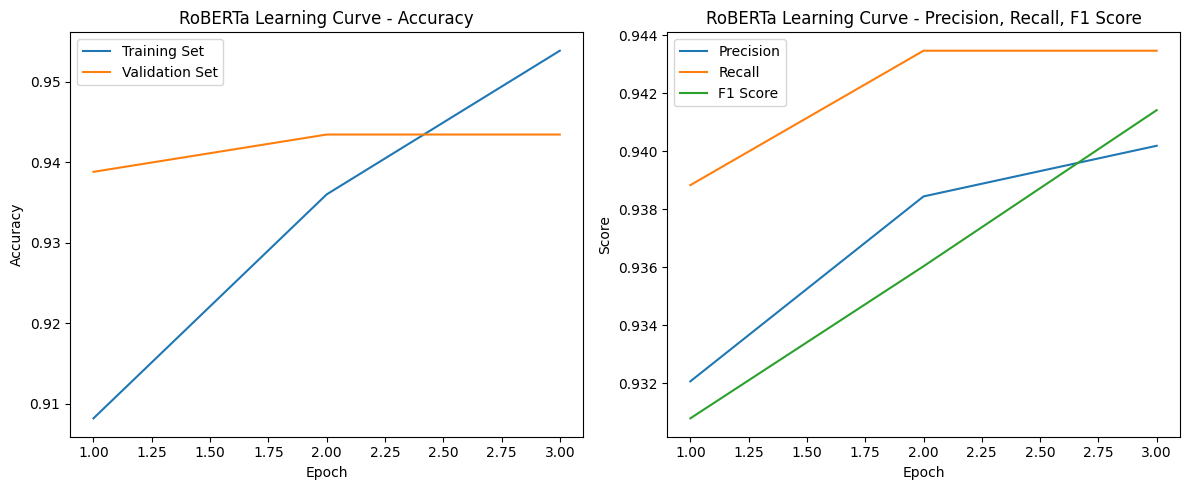

In [ ]:
# Plot learning curve for RoBERTa
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs_roberta + 1), roberta_train_accuracies, label='Training Set')
plt.plot(range(1, epochs_roberta + 1), roberta_val_accuracies, label='Validation Set')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('RoBERTa Learning Curve - Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs_roberta + 1), roberta_val_precisions, label='Precision')
plt.plot(range(1, epochs_roberta + 1), roberta_val_recalls, label='Recall')
plt.plot(range(1, epochs_roberta + 1), roberta_val_f1_scores, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('RoBERTa Learning Curve - Precision, Recall, F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Calculate accuracy for RoBERTa

# Inside the training loop after the training set metrics calculation
accuracy_roberta_train_epoch = accuracy_score(true_labels_roberta_train_epoch, predictions_roberta_train_epoch)

# Inside the validation loop after the validation set metrics calculation
accuracy_roberta_epoch = accuracy_score(true_labels_roberta_epoch, predictions_roberta_epoch)

# Append to the lists for learning curve
roberta_train_accuracies.append(accuracy_roberta_train_epoch)
roberta_val_accuracies.append(accuracy_roberta_epoch)

# Print or log the accuracy
print(f"Epoch {epoch + 1}/{epochs_roberta}, Training Accuracy: {accuracy_roberta_train_epoch:.4f}")
print(f"Epoch {epoch + 1}/{epochs_roberta}, Validation Accuracy: {accuracy_roberta_epoch:.4f}")

Epoch 3/3, Training Accuracy: 0.9539
Epoch 3/3, Validation Accuracy: 0.9435


RoBERTa Training Accuracy Score: 95.39%
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      7838
           1       0.79      0.68      0.73       791

    accuracy                           0.95      8629
   macro avg       0.88      0.83      0.85      8629
weighted avg       0.95      0.95      0.95      8629



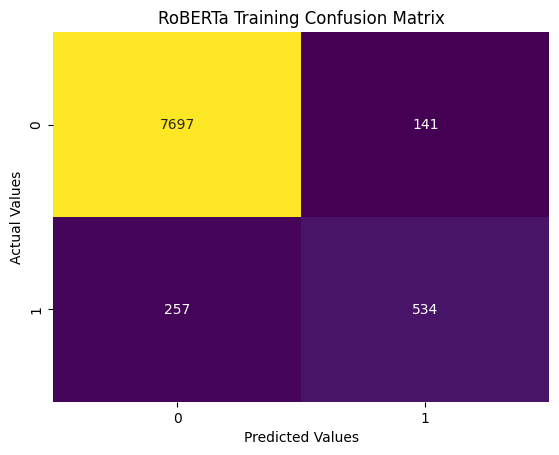

RoBERTa Validation Accuracy Score: 94.35%
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1968
           1       0.71      0.61      0.65       190

    accuracy                           0.94      2158
   macro avg       0.84      0.79      0.81      2158
weighted avg       0.94      0.94      0.94      2158



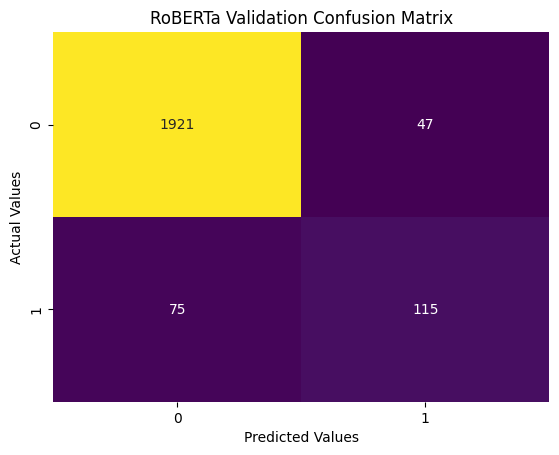

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def my_confusion_matrix(y_true, y_pred, plt_title, accuracy_title):
    cm = confusion_matrix(y_true, y_pred)
    print(f'{accuracy_title} Accuracy Score:', '{:.2%}'.format(accuracy_score(y_true, y_pred)))
    print(classification_report(y_true, y_pred))

    sns.heatmap(cm, annot=True, fmt='g', cbar=False, cmap='viridis')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title(plt_title)
    plt.show()
    return cm

# Visualization for RoBERTa
cm_roberta_train = my_confusion_matrix(true_labels_roberta_train_epoch, predictions_roberta_train_epoch, 'RoBERTa Training Confusion Matrix', 'RoBERTa Training')
cm_roberta_val = my_confusion_matrix(true_labels_roberta_epoch, predictions_roberta_epoch, 'RoBERTa Validation Confusion Matrix', 'RoBERTa Validation')

In [ ]:
# Evaluate and Optimize - Naive Bayes
y_pred_nb = naive_bayes_model.predict(test_features)
cm_nb = confusion_matrix(test_labels, y_pred_nb)
print('Naive Bayes Accuracy Score:', '{:.2%}'.format(accuracy_score(test_labels, y_pred_nb)))
print(classification_report(test_labels, y_pred_nb))

Naive Bayes Accuracy Score: 8.90%
                precision    recall  f1-score   support

non-propaganda       1.00      0.00      0.00      1968
    propaganda       0.09      1.00      0.16       190

      accuracy                           0.09      2158
     macro avg       0.54      0.50      0.08      2158
  weighted avg       0.92      0.09      0.02      2158



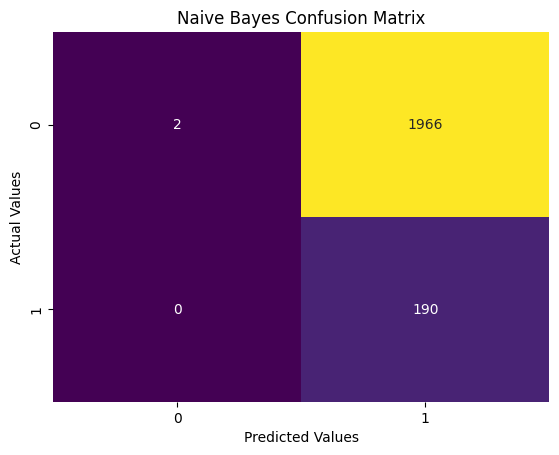

In [ ]:
# Visualize Naive Bayes Confusion Matrix
sns.heatmap(cm_nb, annot=True, fmt='g', cbar=False, cmap='viridis')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Naive Bayes Confusion Matrix')
plt.show()

Value of alpha: 0.1, Training Accuracy: 0.9447, Validation Accuracy: 0.9171
Validation Precision: 0.9175, Recall: 0.9171, F1 Score: 0.8827
Value of alpha: 1, Training Accuracy: 0.9083, Validation Accuracy: 0.9120
Validation Precision: 0.8317, Recall: 0.9120, F1 Score: 0.8700


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Value of alpha: 10, Training Accuracy: 0.9083, Validation Accuracy: 0.9120
Validation Precision: 0.8317, Recall: 0.9120, F1 Score: 0.8700
Value of alpha: 100, Training Accuracy: 0.9083, Validation Accuracy: 0.9120
Validation Precision: 0.8317, Recall: 0.9120, F1 Score: 0.8700


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


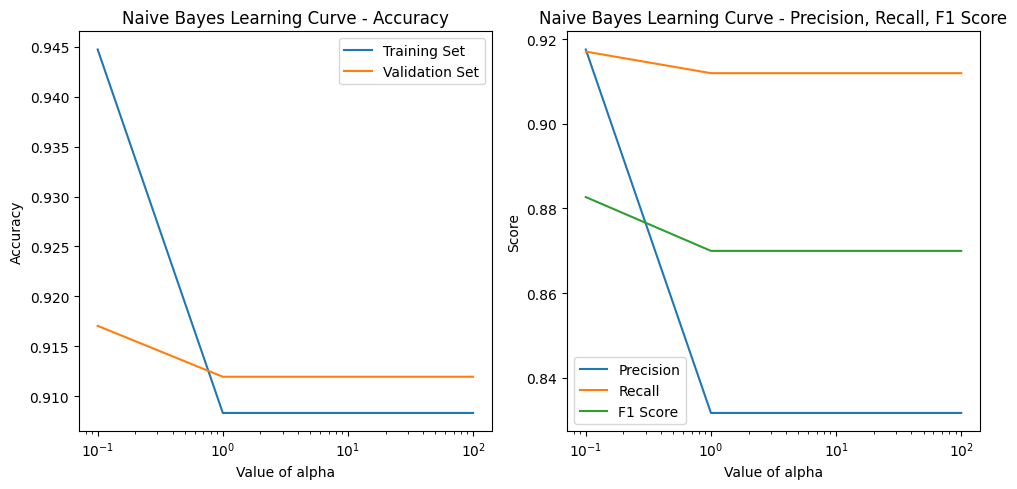

In [ ]:
# Learning Curve for Naive Bayes
alpha_values = [0.1, 1, 10, 100]
train_accuracies_nb = []
val_accuracies_nb = []
val_precisions_nb = []
val_recalls_nb = []
val_f1_scores_nb = []

for alpha in alpha_values:
    nb_model = MultinomialNB(alpha=alpha)
    nb_model.fit(tfidf_matrix_train, train_labels)

    # Training set evaluation
    train_predictions = nb_model.predict(tfidf_matrix_train)
    train_accuracy = accuracy_score(train_labels, train_predictions)
    train_accuracies_nb.append(train_accuracy)

    # Validation set evaluation
    val_predictions = nb_model.predict(tfidf_matrix_test)
    val_accuracy = accuracy_score(test_labels, val_predictions)
    val_accuracies_nb.append(val_accuracy)

    val_precision = precision_score(test_labels, val_predictions, average='weighted')
    val_recall = recall_score(test_labels, val_predictions, average='weighted')
    val_f1 = f1_score(test_labels, val_predictions, average='weighted')

    val_precisions_nb.append(val_precision)
    val_recalls_nb.append(val_recall)
    val_f1_scores_nb.append(val_f1)

    print(f"Value of alpha: {alpha}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")

# Plot learning curve for Naive Bayes
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(alpha_values, train_accuracies_nb, label='Training Set')
plt.plot(alpha_values, val_accuracies_nb, label='Validation Set')
plt.xscale('log')  # Use a logarithmic scale for alpha values
plt.xlabel('Value of alpha')
plt.ylabel('Accuracy')
plt.title('Naive Bayes Learning Curve - Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(alpha_values, val_precisions_nb, label='Precision')
plt.plot(alpha_values, val_recalls_nb, label='Recall')
plt.plot(alpha_values, val_f1_scores_nb, label='F1 Score')
plt.xscale('log')  # Use a logarithmic scale for alpha values
plt.xlabel('Value of alpha')
plt.ylabel('Score')
plt.title('Naive Bayes Learning Curve - Precision, Recall, F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate and Optimize - SVM
y_pred_svm = svm_model.predict(tfidf_matrix_test)
cm_svm = confusion_matrix(test_labels, y_pred_svm)
print('SVM Accuracy Score:', '{:.2%}'.format(accuracy_score(test_labels, y_pred_svm)))
print(classification_report(test_labels, y_pred_svm))

SVM Accuracy Score: 95.32%
                precision    recall  f1-score   support

non-propaganda       0.97      0.98      0.97      1968
    propaganda       0.79      0.63      0.70       190

      accuracy                           0.95      2158
     macro avg       0.88      0.81      0.84      2158
  weighted avg       0.95      0.95      0.95      2158



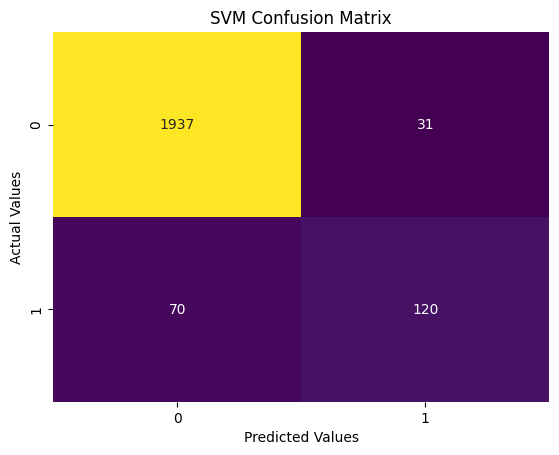

In [ ]:
# Visualize SVM Confusion Matrix
sns.heatmap(cm_svm, annot=True, fmt='g', cbar=False, cmap='viridis')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('SVM Confusion Matrix')
plt.show()

Value of C: 0.1, Training Accuracy: 0.9116, Validation Accuracy: 0.9129
Validation Precision: 0.9205, Recall: 0.9129, F1 Score: 0.8722
Value of C: 1, Training Accuracy: 0.9942, Validation Accuracy: 0.9662
Validation Precision: 0.9650, Recall: 0.9662, F1 Score: 0.9638
Value of C: 10, Training Accuracy: 1.0000, Validation Accuracy: 0.9690
Validation Precision: 0.9677, Recall: 0.9690, F1 Score: 0.9678
Value of C: 100, Training Accuracy: 1.0000, Validation Accuracy: 0.9685
Validation Precision: 0.9672, Recall: 0.9685, F1 Score: 0.9673


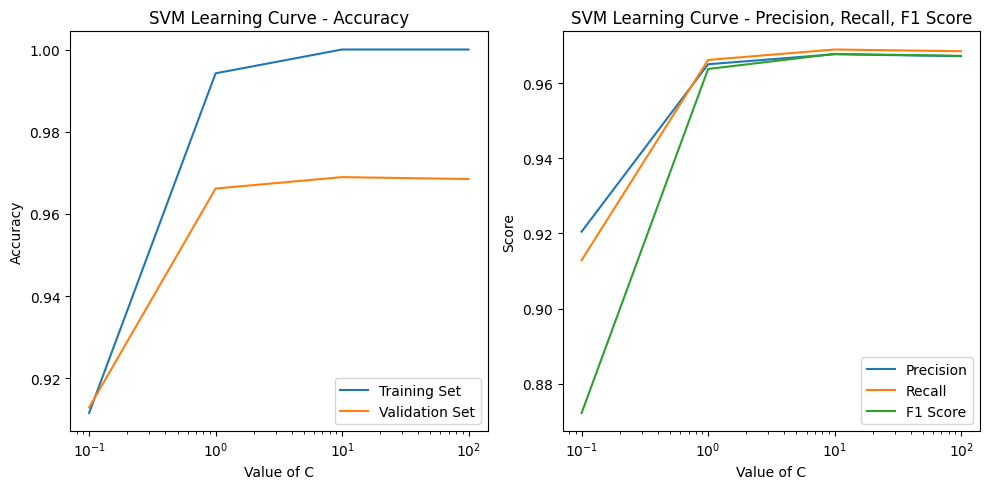

In [ ]:
# Learning Curve for SVM
C_values = [0.1, 1, 10, 100]
train_accuracies_svm = []
val_accuracies_svm = []
val_precisions_svm = []
val_recalls_svm = []
val_f1_scores_svm = []

for C in C_values:
    svm_model = SVC(C=C, kernel='linear')  # You can adjust the kernel as needed
    svm_model.fit(tfidf_matrix_train, train_labels)

    # Training set evaluation
    train_predictions = svm_model.predict(tfidf_matrix_train)
    train_accuracy = accuracy_score(train_labels, train_predictions)
    train_accuracies_svm.append(train_accuracy)

    # Validation set evaluation
    val_predictions = svm_model.predict(tfidf_matrix_test)
    val_accuracy = accuracy_score(test_labels, val_predictions)
    val_accuracies_svm.append(val_accuracy)

    val_precision = precision_score(test_labels, val_predictions, average='weighted')
    val_recall = recall_score(test_labels, val_predictions, average='weighted')
    val_f1 = f1_score(test_labels, val_predictions, average='weighted')

    val_precisions_svm.append(val_precision)
    val_recalls_svm.append(val_recall)
    val_f1_scores_svm.append(val_f1)

    print(f"Value of C: {C}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")

# Plot learning curve for SVM
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(C_values, train_accuracies_svm, label='Training Set')
plt.plot(C_values, val_accuracies_svm, label='Validation Set')
plt.xscale('log')  # Use a logarithmic scale for C values
plt.xlabel('Value of C')
plt.ylabel('Accuracy')
plt.title('SVM Learning Curve - Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(C_values, val_precisions_svm, label='Precision')
plt.plot(C_values, val_recalls_svm, label='Recall')
plt.plot(C_values, val_f1_scores_svm, label='F1 Score')
plt.xscale('log')  # Use a logarithmic scale for C values
plt.xlabel('Value of C')
plt.ylabel('Score')
plt.title('SVM Learning Curve - Precision, Recall, F1 Score')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# K-Nearest Neighbors (KNN)
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix_train = tfidf.fit_transform(train_data['Articles'])
tfidf_matrix_test = tfidf.transform(test_data['Articles'])

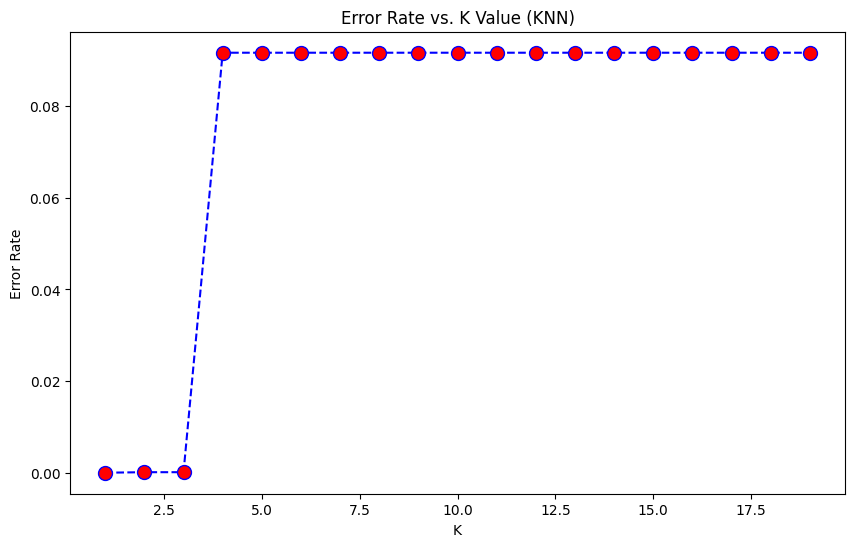

In [ ]:
# Visualization to find the best K value
error_rate = []
for i in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=i, metric='minkowski', p=1)
    knn.fit(tfidf_matrix_train, train_data['Predicted_type'])
    pred_i_knn = knn.predict(tfidf_matrix_train)
    error_rate.append(np.mean(pred_i_knn != train_data['Predicted_type']))

plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), error_rate, color='blue', linestyle='dashed',
         marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value (KNN)')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()

In [ ]:
# Create and train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(tfidf_matrix_train, train_labels)

# Predictions on the test set
y_pred_knn = knn_model.predict(tfidf_matrix_test)

# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred_knn)
print(f'KNN Accuracy Score: {accuracy:.2%}')

# Confusion Matrix
cm_knn = confusion_matrix(test_labels, y_pred_knn)

# Classification Report
print(classification_report(test_labels, y_pred_knn))

KNN Accuracy Score: 93.28%
                precision    recall  f1-score   support

non-propaganda       0.94      0.98      0.96      1968
    propaganda       0.71      0.40      0.51       190

      accuracy                           0.93      2158
     macro avg       0.83      0.69      0.74      2158
  weighted avg       0.92      0.93      0.92      2158



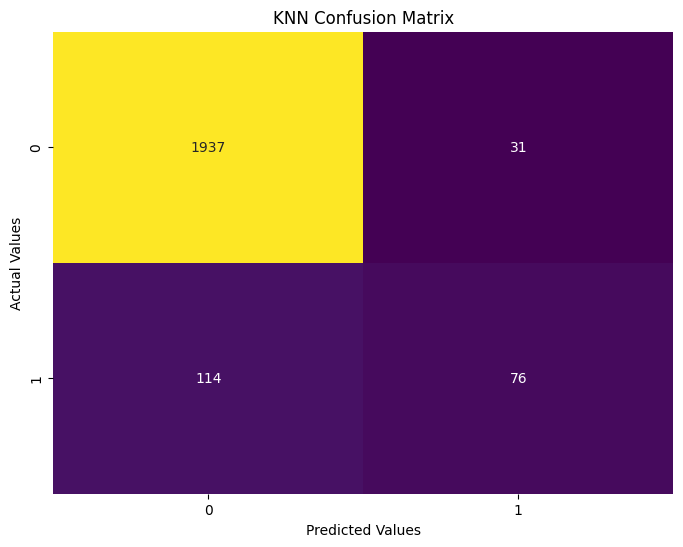

In [ ]:
# Confusion Matrix
cm_knn = confusion_matrix(test_labels, y_pred_knn)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='g', cmap='viridis', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('KNN Confusion Matrix')
plt.show()

In [ ]:
# Learning Curve for KNN
k_values = list(range(1, 31, 2))
train_accuracies_knn = []
val_accuracies_knn = []
val_precisions_knn = []
val_recalls_knn = []
val_f1_scores_knn = []

for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(tfidf_matrix_train, train_labels)

    # Training set evaluation
    train_predictions = knn_model.predict(tfidf_matrix_train)
    train_accuracy = accuracy_score(train_labels, train_predictions)
    train_accuracies_knn.append(train_accuracy)

    # Validation set evaluation
    val_predictions = knn_model.predict(tfidf_matrix_test)
    val_accuracy = accuracy_score(test_labels, val_predictions)
    val_accuracies_knn.append(val_accuracy)

    val_precision = precision_score(test_labels, val_predictions, average='weighted')
    val_recall = recall_score(test_labels, val_predictions, average='weighted')
    val_f1 = f1_score(test_labels, val_predictions, average='weighted')

    val_precisions_knn.append(val_precision)
    val_recalls_knn.append(val_recall)
    val_f1_scores_knn.append(val_f1)

    print(f"Number of Neighbors (k): {k}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")

# Plot learning curve for KNN
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, train_accuracies_knn, label='Training Set')
plt.plot(k_values, val_accuracies_knn, label='Validation Set')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Learning Curve - Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(k_values, val_precisions_knn, label='Precision')
plt.plot(k_values, val_recalls_knn, label='Recall')
plt.plot(k_values, val_f1_scores_knn, label='F1 Score')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Score')
plt.title('KNN Learning Curve - Precision, Recall, F1 Score')
plt.legend()

plt.tight_layout()
plt.show()


Number of Neighbors (k): 1, Training Accuracy: 1.0000, Validation Accuracy: 0.9069
Validation Precision: 0.9058, Recall: 0.9069, F1 Score: 0.9063


In [ ]:
# Create and train the Logistic Regression model
logreg_model = LogisticRegression()
logreg_model.fit(tfidf_matrix_train, train_labels)

# Predictions on the test set
y_pred_logreg = logreg_model.predict(tfidf_matrix_test)

# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred_logreg)
print(f'Logistic Regression Accuracy Score: {accuracy:.2%}')

# Classification Report
print(classification_report(test_labels, y_pred_logreg))

Logistic Regression Accuracy Score: 94.39%
                precision    recall  f1-score   support

non-propaganda       0.95      1.00      0.97      1968
    propaganda       0.92      0.40      0.56       190

      accuracy                           0.94      2158
     macro avg       0.93      0.70      0.76      2158
  weighted avg       0.94      0.94      0.93      2158



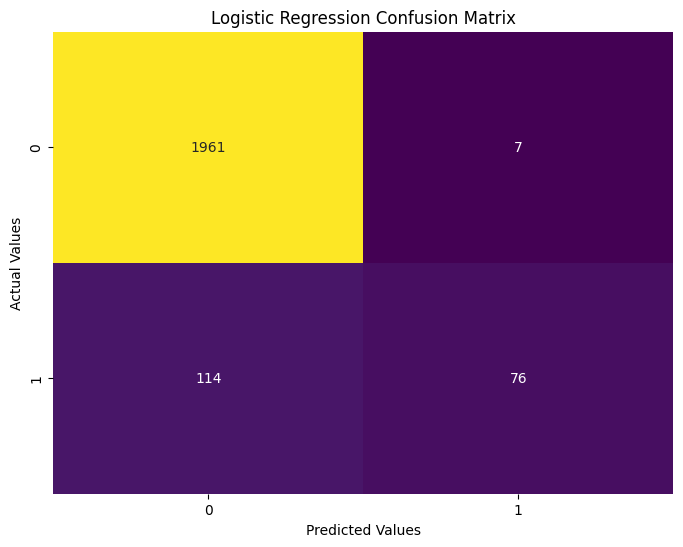

In [ ]:
# Confusion Matrix
cm_logreg = confusion_matrix(test_labels, y_pred_logreg)
# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_logreg, annot=True, fmt='g', cmap='viridis', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Value of C: 0.1, Training Accuracy: 0.9083, Validation Accuracy: 0.9120
Validation Precision: 0.8317, Recall: 0.9120, F1 Score: 0.8700
Value of C: 1, Training Accuracy: 0.9519, Validation Accuracy: 0.9439
Validation Precision: 0.9425, Recall: 0.9439, F1 Score: 0.9337
Value of C: 10, Training Accuracy: 0.9986, Validation Accuracy: 0.9629
Validation Precision: 0.9613, Recall: 0.9629, F1 Score: 0.9602
Value of C: 100, Training Accuracy: 1.0000, Validation Accuracy: 0.9652
Validation Precision: 0.9637, Recall: 0.9652, F1 Score: 0.9632


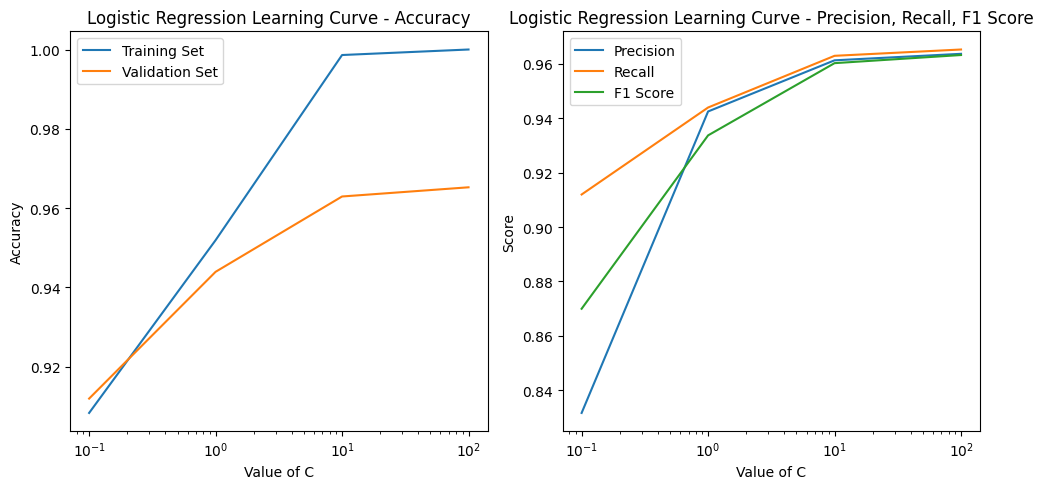

In [ ]:
# Learning Curve for Logistic Regression
C_values = [0.1, 1, 10, 100]
train_accuracies_logreg = []
val_accuracies_logreg = []
val_precisions_logreg = []
val_recalls_logreg = []
val_f1_scores_logreg = []

for C in C_values:
    logreg_model = LogisticRegression(C=C, max_iter=1000, random_state=42)
    logreg_model.fit(tfidf_matrix_train, train_labels)

    # Training set evaluation
    train_predictions = logreg_model.predict(tfidf_matrix_train)
    train_accuracy = accuracy_score(train_labels, train_predictions)
    train_accuracies_logreg.append(train_accuracy)

    # Validation set evaluation
    val_predictions = logreg_model.predict(tfidf_matrix_test)
    val_accuracy = accuracy_score(test_labels, val_predictions)
    val_accuracies_logreg.append(val_accuracy)

    val_precision = precision_score(test_labels, val_predictions, average='weighted')
    val_recall = recall_score(test_labels, val_predictions, average='weighted')
    val_f1 = f1_score(test_labels, val_predictions, average='weighted')

    val_precisions_logreg.append(val_precision)
    val_recalls_logreg.append(val_recall)
    val_f1_scores_logreg.append(val_f1)

    print(f"Value of C: {C}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")

# Plot learning curve for Logistic Regression
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(C_values, train_accuracies_logreg, label='Training Set')
plt.plot(C_values, val_accuracies_logreg, label='Validation Set')
plt.xscale('log')  # Use a logarithmic scale for C values
plt.xlabel('Value of C')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Learning Curve - Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(C_values, val_precisions_logreg, label='Precision')
plt.plot(C_values, val_recalls_logreg, label='Recall')
plt.plot(C_values, val_f1_scores_logreg, label='F1 Score')
plt.xscale('log')  # Use a logarithmic scale for C values
plt.xlabel('Value of C')
plt.ylabel('Score')
plt.title('Logistic Regression Learning Curve - Precision, Recall, F1 Score')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Create and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(tfidf_matrix_train, train_labels)

# Predictions on the test set
y_pred_rf = rf_model.predict(tfidf_matrix_test)

# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred_rf)
print(f'Random Forest Accuracy Score: {accuracy:.2%}')

# Classification Report
print(classification_report(test_labels, y_pred_rf))

Random Forest Accuracy Score: 92.54%
                precision    recall  f1-score   support

non-propaganda       0.92      1.00      0.96      1968
    propaganda       1.00      0.15      0.26       190

      accuracy                           0.93      2158
     macro avg       0.96      0.58      0.61      2158
  weighted avg       0.93      0.93      0.90      2158



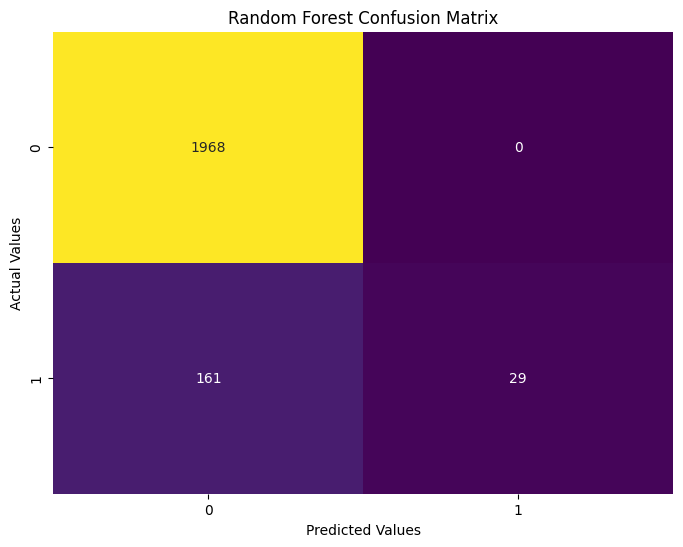

In [ ]:
# Confusion Matrix
cm_rf = confusion_matrix(test_labels, y_pred_rf)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='g', cmap='viridis', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Random Forest Confusion Matrix')
plt.show()

Number of Estimators: 10, Training Accuracy: 0.9911, Validation Accuracy: 0.9245
Validation Precision: 0.9276, Recall: 0.9245, F1 Score: 0.8982
Number of Estimators: 50, Training Accuracy: 0.9998, Validation Accuracy: 0.9259
Validation Precision: 0.9314, Recall: 0.9259, F1 Score: 0.9003
Number of Estimators: 100, Training Accuracy: 1.0000, Validation Accuracy: 0.9254
Validation Precision: 0.9310, Recall: 0.9254, F1 Score: 0.8994
Number of Estimators: 200, Training Accuracy: 1.0000, Validation Accuracy: 0.9254
Validation Precision: 0.9310, Recall: 0.9254, F1 Score: 0.8994


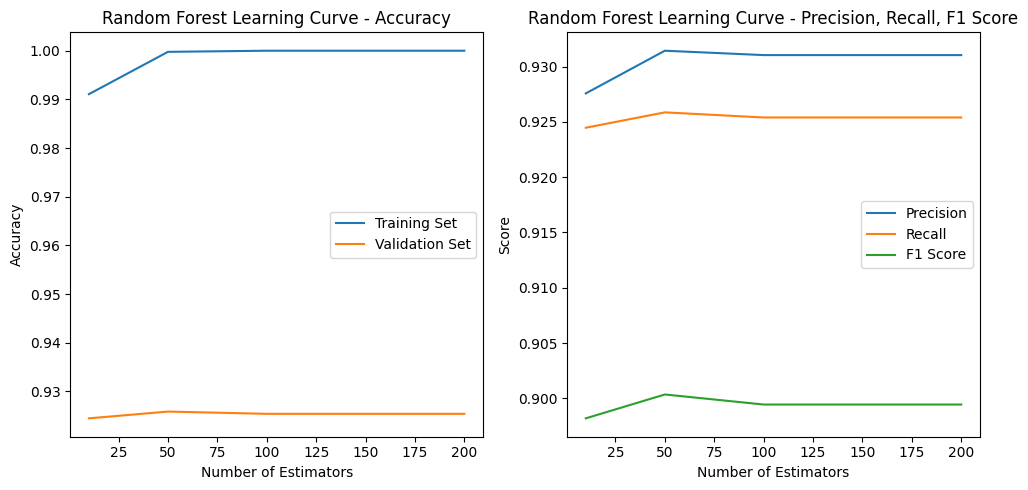

In [ ]:
# Learning Curve for Random Forest
n_estimators_values = [10, 50, 100, 200]
train_accuracies_rf = []
val_accuracies_rf = []
val_precisions_rf = []
val_recalls_rf = []
val_f1_scores_rf = []

for n_estimators in n_estimators_values:
    rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf_model.fit(tfidf_matrix_train, train_labels)

    # Training set evaluation
    train_predictions = rf_model.predict(tfidf_matrix_train)
    train_accuracy = accuracy_score(train_labels, train_predictions)
    train_accuracies_rf.append(train_accuracy)

    # Validation set evaluation
    val_predictions = rf_model.predict(tfidf_matrix_test)
    val_accuracy = accuracy_score(test_labels, val_predictions)
    val_accuracies_rf.append(val_accuracy)

    val_precision = precision_score(test_labels, val_predictions, average='weighted')
    val_recall = recall_score(test_labels, val_predictions, average='weighted')
    val_f1 = f1_score(test_labels, val_predictions, average='weighted')

    val_precisions_rf.append(val_precision)
    val_recalls_rf.append(val_recall)
    val_f1_scores_rf.append(val_f1)

    print(f"Number of Estimators: {n_estimators}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")

# Plot learning curve for Random Forest
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(n_estimators_values, train_accuracies_rf, label='Training Set')
plt.plot(n_estimators_values, val_accuracies_rf, label='Validation Set')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Random Forest Learning Curve - Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(n_estimators_values, val_precisions_rf, label='Precision')
plt.plot(n_estimators_values, val_recalls_rf, label='Recall')
plt.plot(n_estimators_values, val_f1_scores_rf, label='F1 Score')
plt.xlabel('Number of Estimators')
plt.ylabel('Score')
plt.title('Random Forest Learning Curve - Precision, Recall, F1 Score')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Stacking Classifier
stacking_classifier = StackingClassifier(estimators=models, final_estimator=RandomForestClassifier(n_estimators=100, random_state=42))

# Model Training
for model in models:
    model[1].fit(tfidf_matrix_train, train_labels)

stacking_classifier.fit(tfidf_matrix_train, train_labels)

# Stacking Classifier Predictions
stacking_classifier_predictions = stacking_classifier.predict(tfidf_matrix_test)

# Evaluate and Visualize Stacking Classifier
cm_stacking_classifier = my_confusion_matrix(test_labels, stacking_classifier_predictions, 'Stacking Classifier Confusion Matrix', 'Stacking Classifier')

# Visualization for Stacking Classifier
def plot_classifier_performance(classifiers, accuracies, title):
    plt.figure(figsize=(8, 6))
    sns.barplot(x=classifiers, y=accuracies, palette='viridis')
    plt.title(title)
    plt.xlabel('Classifier')
    plt.ylabel('Accuracy')
    plt.show()

# Learning Curve for Stacking Classifier
stacking_train_accuracies = []
stacking_val_accuracies = []
stacking_val_precisions = []
stacking_val_recalls = []
stacking_val_f1_scores = []

n_estimators_values = [50, 100, 150]  # Adjust these values based on your needs

for n_estimators in n_estimators_values:
    stacking_rf_model = StackingClassifier(
        estimators=models + [('RandomForest', RandomForestClassifier(n_estimators=n_estimators, random_state=42))],
        final_estimator=RandomForestClassifier(n_estimators=100, random_state=42)  # Final estimator is now RandomForestClassifier
    )

    # Model Training for base models
    for model in models:
        model[1].fit(tfidf_matrix_train, train_labels)

    # Stacking Classifier Training
    stacking_rf_model.fit(tfidf_matrix_train, train_labels)

    # Training set evaluation
    stacking_train_predictions = stacking_rf_model.predict(tfidf_matrix_train)
    stacking_train_accuracy = accuracy_score(train_labels, stacking_train_predictions)
    stacking_train_accuracies.append(stacking_train_accuracy)

    # Validation set evaluation
    stacking_val_predictions = stacking_rf_model.predict(tfidf_matrix_test)
    stacking_val_accuracy = accuracy_score(test_labels, stacking_val_predictions)
    stacking_val_accuracies.append(stacking_val_accuracy)

     # Precision, Recall, and F1 Score evaluation
    stacking_val_precision = precision_score(test_labels, stacking_val_predictions, average='weighted')
    stacking_val_recall = recall_score(test_labels, stacking_val_predictions, average='weighted')
    stacking_val_f1 = f1_score(test_labels, stacking_val_predictions, average='weighted')

    stacking_val_precisions.append(stacking_val_precision)
    stacking_val_recalls.append(stacking_val_recall)
    stacking_val_f1_scores.append(stacking_val_f1)

    print(f"Number of Estimators: {n_estimators}, Stacking Training Accuracy: {stacking_train_accuracy:.4f}, Stacking Validation Accuracy: {stacking_val_accuracy:.4f}")
    print(f"Stacking Validation Precision: {stacking_val_precision:.4f}, Recall: {stacking_val_recall:.4f}, F1 Score: {stacking_val_f1:.4f}")

# Plot learning curve for Stacking Classifier
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(n_estimators_values, stacking_train_accuracies, label='Stacking Training Set')
plt.plot(n_estimators_values, stacking_val_accuracies, label='Stacking Validation Set')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Stacking Classifier Learning Curve - Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(n_estimators_values, stacking_val_precisions, label='Precision')
plt.plot(n_estimators_values, stacking_val_recalls, label='Recall')
plt.plot(n_estimators_values, stacking_val_f1_scores, label='F1 Score')
plt.xlabel('Number of Estimators')
plt.ylabel('Score')
plt.title('Stacking Classifier Learning Curve - Precision, Recall, F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

NameError: name 'models' is not defined

In [ ]:
# Assuming you have a mapping for label conversion
label_mapping = {'Non propaganda': 0, 'propaganda': 1}

# Convert the predicted labels to integers using the mapping
y_pred_knn_int = [label_mapping.get(label, -1) for label in y_pred_knn]
y_pred_log_int = [label_mapping.get(label, -1) for label in y_pred_logreg]
y_pred_rfc_int = [label_mapping.get(label, -1) for label in y_pred_rf]

# Now, you can calculate the accuracy scores
accuracy_knn = accuracy_score(test_data['Type'], y_pred_knn_int)
accuracy_log = accuracy_score(test_data['Type'], y_pred_log_int)
accuracy_rfc = accuracy_score(test_data['Type'], y_pred_rfc_int)

# Visualization Bar
def plot_classifier_performance(classifiers, accuracies, title):
    plt.figure(figsize=(12, 8))

    # Convert accuracies to percentage
    accuracies_percent = [acc * 100 for acc in accuracies]

    # Use a color palette for better visibility
    colors = sns.color_palette("viridis", len(classifiers))

    # Create a bar plot with custom colors
    ax = sns.barplot(x=classifiers, y=accuracies_percent, palette=colors)

    # Add data labels on top of the bars with improved styling
    for i, (acc, acc_absolute) in enumerate(zip(accuracies_percent, accuracies)):
        ax.text(i, acc + 1, f'{acc_absolute:.0f}\n{acc:.2f}%', ha='center', va='bottom', color='white', fontweight='bold', fontsize=12)

    # Add data labels on top of the bars
    for i, acc in enumerate(accuracies_percent):
        ax.text(i, acc + 1, f'{acc:.2f}%', ha='center', va='bottom', color='black', fontweight='bold', fontsize=10)

    # Customize plot aesthetics
    ax.set_title(title, fontsize=18, fontweight='bold', color='navy')
    ax.set_xlabel('Classifier', fontsize=16, fontweight='bold', color='navy')
    ax.set_ylabel('Accuracy (%)', fontsize=16, fontweight='bold', color='navy')
    ax.set_ylim(0, 100)

    # Add a grid for clarity
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Customize tick labels
    ax.tick_params(axis='x', labelrotation=45, labelsize=12, colors='darkslategray')
    ax.tick_params(axis='y', labelsize=12, colors='darkslategray')

    # Display the plot
    plt.show()

# Collect classifier names and corresponding accuracies
classifier_names = ['Naive Bayes', 'SVM', 'KNN', 'Logistic Regression', 'Random Forest', 'Stacking Classifier', 'RoBERTa']
classifier_accuracies = [
    accuracy_score(test_labels, y_pred_nb),
    accuracy_score(test_labels, y_pred_svm),
    accuracy_knn,
    accuracy_log,
    accuracy_rfc,
    accuracy_score(test_labels, stacking_classifier_predictions),
    accuracy_roberta_epoch
]

# Plot the enhanced bar chart
plot_classifier_performance(classifier_names, classifier_accuracies, 'Classifier Performance Comparison')